In [46]:
from netCDF4 import Dataset as DS
import numpy as np
import matplotlib.pyplot as pl
import os
import glob
import re
from tqdm import tqdm_notebook
% matplotlib inline

In [44]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [34]:
bands = [412, 443, 490, 510, 555, 670, 765, 865]
bandNums = {band:i for band,i in zip(bands,range(8))}
intensities = [1, 5]

In [35]:
pert4DFilePattern = re.compile('(S[0-9]+.L3m_4D.+)')

In [36]:
mainDir = '/accounts/ekarakoy/disk02/UNCERTAINTIES/Systematic_Error/PACE_SWF/'
pertDataDir = 'BandWise/'
bslDataDir = 'Baseline/'
# Will have to add mainDir to the paths listed in the dict. below
relPathsDict = dict.fromkeys(['band%d_0p%dp' % (i,j) for i in range(8) for j in [1,5]]
                              + ['baseline'])
dataDict = dict.fromkeys([k for k in relPathsDict.keys() if k!='baseline'])
bslDict = dict.fromkeys(['Lt', 'Rrs', 'Geo'])

In [39]:
# load dictionary with relative paths to 4D data files, including baseline data
for k in relPathsDict.keys():
    if k == 'baseline':
        path = os.path.join(mainDir, bslDataDir, '*')
    else:
        path = os.path.join(mainDir, pertDataDir, k, '*')
    for l in glob.iglob(path):
        fileMatch = pert4DFilePattern.findall(l)
        if fileMatch:
            relPathsDict[k] = os.path.join(re.findall('(B[0-9a-zA-Z\W_]+)\*',
                                                      path)[0], fileMatch[0])

In [58]:
relPathsDict.keys()

dict_keys(['band0_0p5p', 'band7_0p1p', 'band5_0p1p', 'band0_0p1p', 'band5_0p5p', 'band2_0p1p', 'band2_0p5p', 'band4_0p5p', 'band4_0p1p', 'baseline', 'band1_0p1p', 'band6_0p1p', 'band7_0p5p', 'band1_0p5p', 'band6_0p5p', 'band3_0p1p', 'band3_0p5p'])

In [40]:
# TEST Paths exist:
for v in relPathsDict.values():
    stat = os.path.exists(os.path.join(mainDir, v))
    print('%s exists? %s' %(v, stat))

BandWise/band0_0p5p/S20031932003196.L3m_4D_BWES09.nc exists? True
BandWise/band7_0p1p/S20031932003196.L3m_4D_BWES08.nc exists? True
BandWise/band5_0p1p/S20031932003196.L3m_4D_BWES06.nc exists? True
BandWise/band0_0p1p/S20031932003196.L3m_4D_BWES01.nc exists? True
BandWise/band5_0p5p/S20031932003196.L3m_4D_BWES14.nc exists? True
BandWise/band2_0p1p/S20031932003196.L3m_4D_BWES03.nc exists? True
BandWise/band2_0p5p/S20031932003196.L3m_4D_BWES11.nc exists? True
BandWise/band4_0p5p/S20031932003196.L3m_4D_BWES13.nc exists? True
BandWise/band4_0p1p/S20031932003196.L3m_4D_BWES05.nc exists? True
Baseline/S20031932003196.L3m_4D_PSES00.nc exists? True
BandWise/band1_0p1p/S20031932003196.L3m_4D_BWES02.nc exists? True
BandWise/band6_0p1p/S20031932003196.L3m_4D_BWES07.nc exists? True
BandWise/band7_0p5p/S20031932003196.L3m_4D_BWES16.nc exists? True
BandWise/band1_0p5p/S20031932003196.L3m_4D_BWES10.nc exists? True
BandWise/band6_0p5p/S20031932003196.L3m_4D_BWES15.nc exists? True
BandWise/band3_0p1p/S

In [77]:
def GetL3mProds(path, verbose=True, getLatLon=False):
    """Loads data into dictionaries for Lt and Rrs."""
    ltDict = dict.fromkeys(bands)
    rrsDict = dict.fromkeys(bands[:-2])
    with DS(path) as ds:
        varbls = ds.variables
        for band in bands:
            try:
                ltDict[band] = varbls['Lt_%d' % band][:].data
                rrsDict[band] = varbls['Rrs_%d' % band][:].data
            except KeyError as e:
                if verbose:
                    print(e, ' ... skipping')
                continue
        if getLatLon:
            for k in ['lat', 'lon']:
                geoDict = {k: varbls[k][:]}
            return ltDict, rrsDict, geoDict
    return ltDict, rrsDict


def ComputeTable(verbose=True):
    path = os.path.join(mainDir, relPathsDict['baseline'])
    _, rrsBslDict, geoDict = GetL3mProds(path, verbose=False, getLatLon=True)
    rrsDiffDict_0p1 = dict.fromkeys(bands[:-2])
    rrsDiffDict_0p5 = dict.fromkeys(bands[:-2])
    for band in bands[:-2]:
        rrsDiffDict_0p1[band] = np.zeros_like(rrsBslDict[band])
        rrsDiffDict_0p5[band] = np.zeros_like(rrsBslDict[band])
        
    for k, v in tqdm_notebook(relPathsDict.items()):
        if k == 'baseline':
            continue
        path = os.path.join(mainDir, v)
        _, rrsDict = GetL3mProds(path, verbose=False)
        for band in bands[:-2]:
            diff = np.power(rrsDict[band] - rrsBslDict[band], 2)

            if '0p1p' in k:
                if verbose:
                    print("%d - 0.1p" % band)
                rrsDiffDict_0p1[band] += diff
                    
            elif '0p5p' in k:
                if verbose:
                    print("%d - 0.5p" % band)
                rrsDiffDict_0p5[band] += diff
    for band in bands[:-2]:
        rrsDiffDict_0p1[band] = np.sqrt(rrsDiffDict_0p1[band])
        rrsDiffDict_0p5[band] = np.sqrt(rrsDiffDict_0p5[band])
    return rrsDiffDict_0p1, rrsDiffDict_0p5, geoDict


def GetMasks():
    
    ltMskDict, rrsMskDict = GetL3mProds(os.path.join(mainDir, relPathsDict['baseline']),
                                               justMasks=True, verbose=False)
    for k, v in tqdm_notebook(relPathsDict.items()):
        if k =='baseline':
            continue
        path = os.path.join(mainDir, v)
        tmpLtMskDict, tmpRrsMskDict = GetL3mProds(path, verbose=False, justMasks=True)
        for band in bands:
            ltMskDict[band] += tmpLtMskDict[band]
            try:
                rrsMskDict[band] += tmpRrsMskDict[band]
            except KeyError as e:
                continue
    return {'Lt': ltMskDict, 'Rrs': rrsMskDict}
                
def ComputeDiffs(prtData, bslData, computeRel=True):
    diff = prtData - bslData
    if computeRel:
        reldiff = diff / bslData
        return diff, reldiff
    return diff


In [45]:
bslDict['Lt'], bslDict['Rrs'], bslDict['Geo'] = GetL3mProds(os.path.join(mainDir,
                                                                         relPathsDict['baseline']
                                                                        ), getLatLon=True
                                                           )

'Rrs_765'  ... skipping
'Rrs_865'  ... skipping


In [57]:
mskDict = GetMasks()

In [78]:
rdd0p1, rdd0p5, gd = ComputeTable(verbose=False)

In [92]:
pickle.dump(rdd0p1, open('./Data/rrsSumSqDiffDict0p1.pkl', 'wb'))
pickle.dump(rdd0p5, open('./Data/rrsSumSqDiffDict0p5.pkl', 'wb'))
pickle.dump(gd, open('./Data/geoDict.pkl', 'wb'))

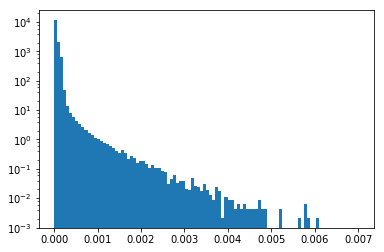

In [91]:
pl.hist(rdd0p1[412].flatten(), range=(0,7e-3), bins=100, normed=True, log=True);